<a id="install"></a>
## Package installation
Before you use the sample code in this notebook, install the following packages:
 - ibm_watson_machine_learning,
 - autoai-libs,
 - xgboost.


In [1]:
!pip install ibm-watson-machine-learning | tail -n 1
!pip install -U autoai-libs==1.12.5 | tail -n 1
!pip install -U xgboost==0.90 | tail -n 1

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: Cryptograp

<a id="variables_definition"></a>
## AutoAI experiment metadata
The following cell contains the training data connection details.  
**Note**: The connection might contain authorization credentials, so be careful when sharing the notebook.

In [2]:
# @hidden_cell
from ibm_watson_machine_learning.helpers import DataConnection
from ibm_watson_machine_learning.helpers import S3Connection, S3Location

training_data_reference = [DataConnection(
    connection=S3Connection(
        api_key='-0hzj7D4OYBdBfbMEuABibpFJU5NIGlHcp25FnWTksIg',
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net'
    ),
        location=S3Location(
        bucket='bigmartsates-donotdelete-pr-zivrdoivomqhzt',
        path='BigMart_dataset.csv'
    )),
]
training_result_reference = DataConnection(
    connection=S3Connection(
        api_key='-0hzj7D4OYBdBfbMEuABibpFJU5NIGlHcp25FnWTksIg',
        auth_endpoint='https://iam.bluemix.net/oidc/token/',
        endpoint_url='https://s3-api.us-geo.objectstorage.softlayer.net'
    ),
    location=S3Location(
        bucket='bigmartsates-donotdelete-pr-zivrdoivomqhzt',
        path='auto_ml/f4b0bf2d-413c-4859-ac33-6cc112e64f38/wml_data/c09a97ed-c4b8-484c-8ed1-575227e10eeb/data/automl',
        model_location='auto_ml/f4b0bf2d-413c-4859-ac33-6cc112e64f38/wml_data/c09a97ed-c4b8-484c-8ed1-575227e10eeb/data/automl/hpo_c_output/Pipeline1/model.pickle',
        training_status='auto_ml/f4b0bf2d-413c-4859-ac33-6cc112e64f38/wml_data/c09a97ed-c4b8-484c-8ed1-575227e10eeb/training-status.json'
    ))

Following cell contains input parameters provided to run the AutoAI experiment in Watson Studio.

In [3]:
experiment_metadata = dict(
   prediction_type='regression',
   prediction_column='Item_Outlet_Sales',
   holdout_size=0.1,
   scoring='neg_root_mean_squared_error',
   deployment_url='https://us-south.ml.cloud.ibm.com',
   csv_separator=',',
   random_state=33,
   max_number_of_estimators=2,
   daub_include_only_estimators=None,
   training_data_reference=training_data_reference,
   training_result_reference=training_result_reference,
   project_id='c8fa43cd-5d3d-4fd1-aac5-61b45c83ece5'
)

<a id="read"></a>
## Dataset Exploratory Analysis


In [4]:
df = training_data_reference[0].read(csv_separator=experiment_metadata['csv_separator'])
df.dropna('rows', how='any', subset=[experiment_metadata['prediction_column']], inplace=True)

In [5]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### importing visualization libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.patches as mpatches

 ### exploring data

In [7]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800



#### Exploring relationship between attributes

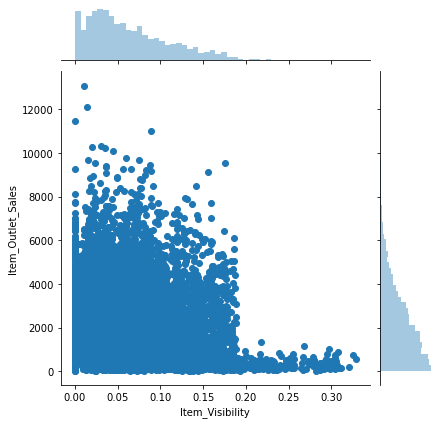

In [9]:
sns.jointplot(x=df["Item_Visibility"], y=df["Item_Outlet_Sales"], kind='scatter')

plt.show()

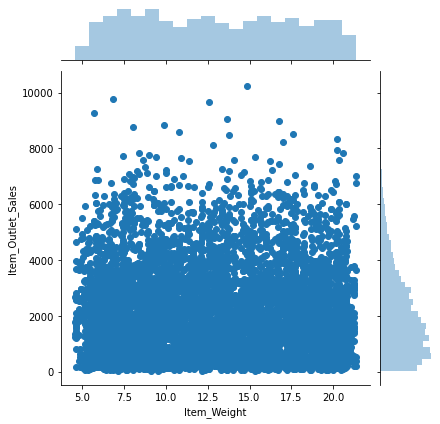

In [10]:
sns.jointplot(x=df["Item_Weight"], y=df["Item_Outlet_Sales"], kind='scatter')

plt.show()

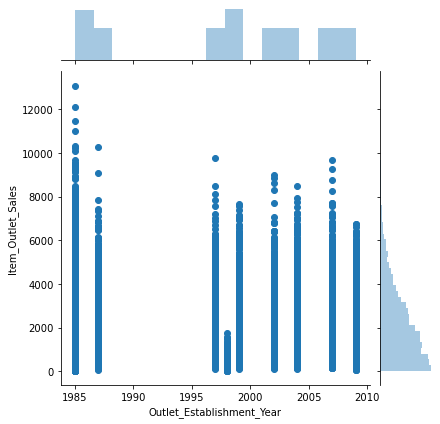

In [12]:
sns.jointplot(x=df["Outlet_Establishment_Year"], y=df["Item_Outlet_Sales"], kind='scatter')

plt.show()

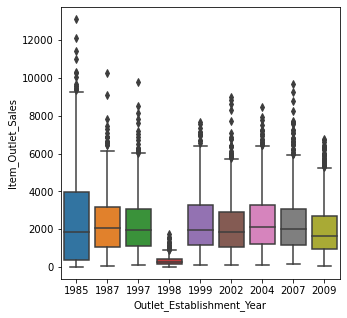

In [13]:
plt.figure(figsize = (5, 5))
sns.boxplot(x = 'Outlet_Establishment_Year', y = 'Item_Outlet_Sales',  data = df)

In [21]:
# claim_corr = df[['Outlet_Establishment_Year', 'Item_Weight', 'Item_Outlet_Sales']].corr()

<a id="split"></a>
##  Train and test data split

In [22]:
from sklearn.model_selection import train_test_split

df.drop_duplicates(inplace=True)
X = df.drop([experiment_metadata['prediction_column']], axis=1).values
y = df[experiment_metadata['prediction_column']].values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=experiment_metadata['holdout_size'],
                                                    random_state=experiment_metadata['random_state'])

<a id="preview_model_to_python_code"></a>
## Make pipeline
In the next cell, you can find the Scikit-learn definition of the selected AutoAI pipeline.

Import statements.

In [23]:
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from sklearn.pipeline import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from sklearn.pipeline import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from autoai_libs.cognito.transforms.transform_utils import TAM
from sklearn.decomposition import PCA
from autoai_libs.cognito.transforms.transform_utils import FS1
from autoai_libs.cognito.transforms.transform_utils import TA1
import autoai_libs.utils.fc_methods
from xgboost import XGBRegressor

#### Pre-processing & Estimator.

In [24]:
numpy_column_selector_0 = NumpyColumnSelector(
    columns=[0, 2, 4, 6, 7, 8, 9, 10]
)
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "char_str",
        "char_str",
        "char_str",
        "char_str",
        "int_num",
        "char_str",
        "char_str",
        "char_str",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[[], [], [], [], [], [float("nan")], [], []],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    missing_values=[float("nan")], filling_values=float("nan")
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=float("nan"),
    filling_values_list=[
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
        float("nan"),
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    strategy="most_frequent",
    missing_values=float("nan"),
    sklearn_version_family="23",
)
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="23",
)
pipeline_0 = make_pipeline(
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
numpy_column_selector_1 = NumpyColumnSelector(columns=[1, 3, 5])
float_str2_float = FloatStr2Float(
    dtypes_list=["float_num", "float_num", "float_num"],
    missing_values_reference_list=[float("nan")],
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    missing_values=[float("nan")], filling_values=float("nan")
)
num_imputer = NumImputer(strategy="median", missing_values=float("nan"))
opt_standard_scaler = OptStandardScaler(
    num_scaler_copy=None,
    num_scaler_with_mean=None,
    num_scaler_with_std=None,
    use_scaler_flag=False,
)
pipeline_1 = make_pipeline(
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0, permutation_indices=[0, 2, 4, 6, 7, 8, 9, 10, 1, 3, 5]
)
tam = TAM(
    tans_class=PCA(),
    name="pca",
    col_names=[
        "Item_Identifier",
        "Item_Weight",
        "Item_Fat_Content",
        "Item_Visibility",
        "Item_Type",
        "Item_MRP",
        "Outlet_Identifier",
        "Outlet_Establishment_Year",
        "Outlet_Size",
        "Outlet_Location_Type",
        "Outlet_Type",
    ],
    col_dtypes=[
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_0 = FS1(
    cols_ids_must_keep=range(0, 11),
    additional_col_count_to_keep=12,
    ptype="regression",
)
ta1 = TA1(
    fun=np.sqrt,
    name="sqrt",
    datatypes=["numeric"],
    feat_constraints=[
        autoai_libs.utils.fc_methods.is_non_negative,
        autoai_libs.utils.fc_methods.is_not_categorical,
    ],
    col_names=[
        "Item_Identifier",
        "Item_Weight",
        "Item_Fat_Content",
        "Item_Visibility",
        "Item_Type",
        "Item_MRP",
        "Outlet_Identifier",
        "Outlet_Establishment_Year",
        "Outlet_Size",
        "Outlet_Location_Type",
        "Outlet_Type",
        "pca_0",
        "pca_1",
        "pca_2",
        "pca_3",
        "pca_4",
        "pca_5",
        "pca_6",
        "pca_7",
        "pca_8",
        "pca_9",
        "pca_10",
    ],
    col_dtypes=[
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
        np.dtype("float32"),
    ],
)
fs1_1 = FS1(
    cols_ids_must_keep=range(0, 11),
    additional_col_count_to_keep=12,
    ptype="regression",
)
xgb_regressor = XGBRegressor(
    gamma=0.7258542214206876,
    learning_rate=0.02,
    min_child_weight=20,
    n_estimators=319,
    n_jobs=2,
    objective="reg:squarederror",
    random_state=33,
    reg_alpha=0.32681018560472175,
    reg_lambda=0.10155046152079605,
    silent=True,
    subsample=0.7444835249102951,
    verbosity=0,
)


Pipeline.

In [25]:
pipeline = make_pipeline(
    union, numpy_permute_array, tam, fs1_0, ta1, fs1_1, xgb_regressor
)

<a id="train"></a>
## Train pipeline model


### Define scorer from the optimization metric
This cell constructs the cell scorer based on the experiment metadata.

In [26]:
from sklearn.metrics import get_scorer

scorer = get_scorer(experiment_metadata['scoring'])

<a id="test_model"></a>
### Fit pipeline model
In this cell, the pipeline is fitted.

In [27]:
pipeline.fit(train_X,train_y)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('numpycolumnselector',
                                                                  NumpyColumnSelector(columns=[0,
                                                                                               2,
                                                                                               4,
                                                                                               6,
                                                                                               7,
                                                                                               8,
                                                                                               9,
                                                                                               10])),
                           

<a id="test_model"></a>
## Test pipeline model

Score the fitted pipeline with the generated scorer using the holdout dataset.

In [28]:
score = scorer(pipeline, test_X, test_y)
print(score)

-1107.167785383792


<a id="copyrights"></a>
### Copyrights

Licensed Materials - Copyright © 2021 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs  
(or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms),  
such agreements located in the link below. Specifically, the Source Components and Sample Materials clause  
included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BYC7LF">License Terms</a>

___